# Аналитика в Яндекс.Афише

## Описание проекта:
Нам необходимо провести анализ, чтобы корректно оптимизировать маркетинговые затраты.
У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- Таблица visits: лог сервера с данными о посещениях сайта Яндекс.Афиши,
- Таблица orders: выгрузка всех заказов за этот период,
- Таблица costs: статистика рекламных расходов.

#### Нам необходимо изучить:

- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

#### Описание данных:

Таблица visits (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Оглавление:
I.   [Открытие и предобработка данных](#start)
 * [Первые выводы](#start_conc)
 * [Выводы по продуктовым метрикам](#prod_conc)
 * [Метрики продаж](#sales)
 * [Выводы по метрикам продаж](#sales_conc)
 * [Маркетинговые метрики](#mark)
 * [Выводы по маркетинговым метрикам](#mark_conc)

II.  [Подготовка данных](#second)

III. [Формирование отчётов и расчет метрик](#third)
 * [Продуктовые метрики](#prod)

IV. [Общий вывод](#final_conc)

## I. Открытие данных  <a id="start"></a>

##### Подключим необходимые библиотеки python

In [110]:
import pandas as pd
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from IPython.display import display
%matplotlib inline
import numpy as np
from io import BytesIO
import requests
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)

##### Загрузим данные

In [111]:
def data_from_g_sheets(spreadsheet_id):
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    return pd.read_csv(BytesIO(r.content))

In [112]:
try:
    visits = pd.read_csv('/datasets/visits_log.csv')
    orders = pd.read_csv('/datasets/orders_log.csv')
    costs = pd.read_csv('/datasets/costs.csv')
except:
    visits = data_from_g_sheets('19oYw2J-HeD-CIt7aE5iPtUlmWneznF7gmiV8nPEw-EI')
    orders = data_from_g_sheets('1QLVr3CsH4Ui_jBUNLswlSarFDKg-PH3ww87jMcNHqFU')
    costs = data_from_g_sheets('1hHxJ9b8pE8WSoAJXtVsCyj3sI-XUHc6lduTZiXiH21Y')

In [113]:
display(visits.head(5))

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 1:54:00,5,2017-07-01 1:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [114]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  object
dtypes: int64(1), object(4)
memory usage: 13.7+ MB


In [115]:
visits.isna().mean()

Device       0.0
End Ts       0.0
Source Id    0.0
Start Ts     0.0
Uid          0.0
dtype: float64

In [116]:
display(orders.head(5))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [117]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [118]:
orders.isna().mean()

transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

In [119]:
display(costs.head(5))

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [120]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [121]:
costs.isna().mean()

source_id    0.0
dt           0.0
costs        0.0
dtype: float64

In [122]:
visits.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

### Вывод: <a id="start_conc"></a>
Пропусков данных нет, но столбцы с датами представлены в формате Object. Это нужно исправить. Также, для удобства воспритятия мы поменяем местами столбцы `End Ts` и `Start Ts` в таблице visits и приведем все названия столбцов к нижнему регистру.

## II. Подготовка данных  <a id="second"></a>

In [123]:
visits.columns = [col.lower() for col in visits.columns]
orders.columns = [col.lower() for col in orders.columns]
costs.columns = [col.lower() for col in costs.columns]

In [124]:
visits = visits[['device','source id','uid','start ts','end ts']]

In [125]:
visits['start ts'] = pd.to_datetime(visits['start ts'])
visits['end ts'] = pd.to_datetime(visits['end ts'])

In [126]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   source id  359400 non-null  int64         
 2   uid        359400 non-null  object        
 3   start ts   359400 non-null  datetime64[ns]
 4   end ts     359400 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 13.7+ MB


In [129]:
orders.head(10)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [130]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [131]:
costs['dt'].dtypes

dtype('<M8[ns]')

## III. Формирование отчётов и расчет метрик <a id="third"></a>
 Сегментируем наш анализ по типам метрик:  Продуктовые, Метрики продаж и Маркетиновые.

### Продуктовые метрики: <a id="prod"></a>

##### Выясним сколько людей пользуются продуктом в день, неделю, месяц. Посмотрим на DAU, WAU и MAU.


###### Для начала добавим необходимые для анализа столбцы.

In [132]:
visits['date'] = visits['start ts'].dt.date
visits['week'] = visits['start ts'].dt.week
visits['month'] = visits['start ts'].dt.month
visits['year'] = visits['start ts'].dt.year
visits['weekday'] = visits['start ts'].dt.weekday
visits['month_year'] = pd.to_datetime(visits['start ts']).dt.to_period('M')
visits['week_year'] = visits['start ts'].dt.strftime('%Y-%W')

In [133]:
display(visits.sample(5))

,device,source id,uid,start ts,end ts,date,week,month,year,weekday,month_year,week_year
45666,desktop,3,6201785720468603528,2017-09-25 15:57:00,2017-09-25 15:57:00,2017-09-25,39,9,2017,0,2017-09,2017-39
195909,touch,4,14449697514526373418,2017-07-19 17:46:00,2017-07-19 17:48:00,2017-07-19,29,7,2017,2,2017-07,2017-29
286972,touch,3,4265650735546406639,2018-02-09 10:02:00,2018-02-09 10:22:00,2018-02-09,6,2,2018,4,2018-02,2018-06
69216,desktop,5,7902511316735390075,2017-07-06 19:25:00,2017-07-06 19:25:00,2017-07-06,27,7,2017,3,2017-07,2017-27
244115,desktop,5,7774850637171158831,2018-02-04 23:25:00,2018-02-04 23:35:00,2018-02-04,5,2,2018,6,2018-02,2018-05


###### Узнаем сколько у нас всего уникальных ползователей.

In [134]:
print('Всего уникальных пользователей:', visits['uid'].drop_duplicates().count())

Всего уникальных пользователей: 228169


##### Сгруппируем уникальных пользвателей по дате / неделе года / месяцу года.

In [135]:
users_per_date = visits.groupby(by= 'date').agg({'uid': ['nunique']}).reset_index()
users_per_date.columns = ['date', 'users']

users_per_week = visits.groupby(by= ['year', 'week_year']).agg({'uid': ['nunique']}).reset_index()
users_per_week.columns = ['year', 'week_year', 'users']

users_per_month = visits.groupby(by= ['year', 'month_year']).agg({'uid': ['nunique']}).reset_index()
users_per_month.columns = ['year', 'month_year', 'users']


##### Посмотрим на DAU (Daily Active Users).

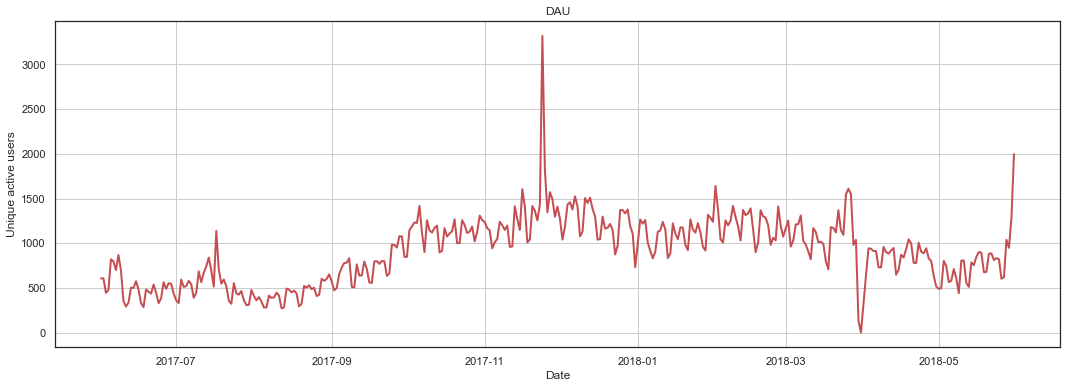

In [136]:
pd.options.mode.chained_assignment = None
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(data=users_per_date, x = 'date', y = 'users', color = 'r', linewidth = 2)

plt.grid(True)
plt.title('DAU')
plt.xlabel('Date')
plt.ylabel('Unique active users')
plt.show()

In [137]:
print('Среднее количество активных уникальных юзеров в день за весь период:', int(users_per_date['users'].mean()))
print('Медианное количество активных уникальных юзеров в день за весь период:', int(users_per_date['users'].median()))

Среднее количество активных уникальных юзеров в день за весь период: 907
Медианное количество активных уникальных юзеров в день за весь период: 921


##### Посмотрим на WAU (Week Active Users).

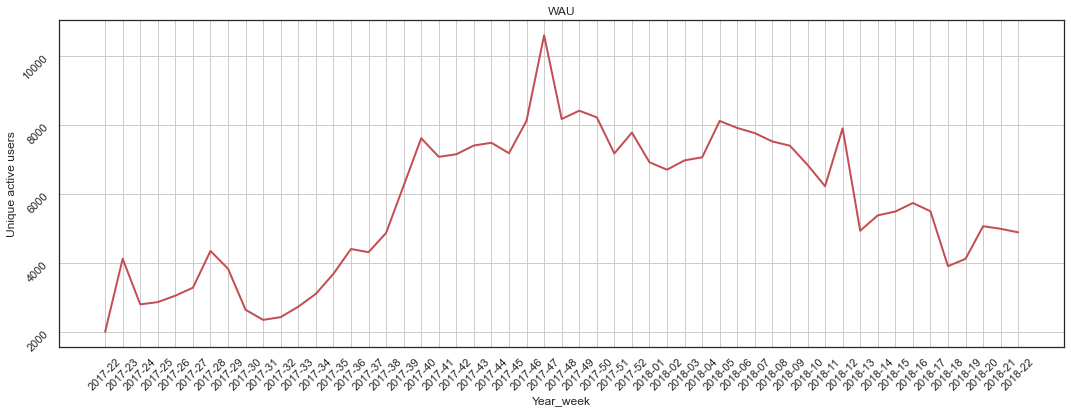

In [138]:
x = np.arange(0,len(users_per_week),1)
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(x,users_per_week['users'],color = 'r', linewidth = 2)
ax.set_xticks(x)
ax.set_xticklabels(users_per_week['week_year'])
ax.tick_params(labelrotation = 45)

plt.grid(True)
plt.title('WAU')
plt.xlabel('Year_week')
plt.ylabel('Unique active users')
plt.show()

In [139]:
print('Среднее количество активных уникальных юзеров в неделю за весь период:', int(users_per_week['users'].mean()))
print('Медианное количество активныхуникальных юзеров в неделю за весь период:', int(users_per_week['users'].median()))

Среднее количество активных уникальных юзеров в неделю за весь период: 5716
Медианное количество активныхуникальных юзеров в неделю за весь период: 5740


##### Посмотрим на MAU (Month Active Users).

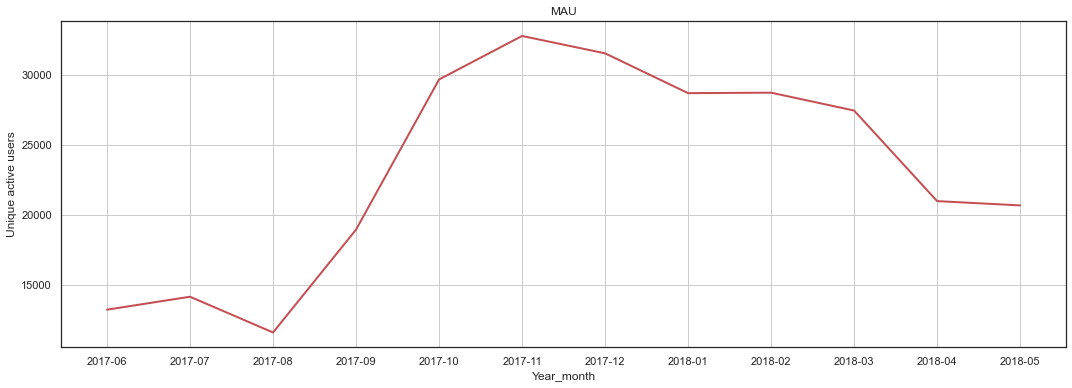

In [140]:
x = np.arange(0,len(users_per_month),1)
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(x,users_per_month['users'], color = 'r', linewidth = 2)
ax.set_xticks(x)
ax.set_xticklabels(users_per_month['month_year'])

plt.grid(True)
plt.title('MAU')
plt.xlabel('Year_month')
plt.ylabel('Unique active users')
plt.show()

In [141]:
print('Среднее количество активных уникальных юзеров в месяц за весь период:', int(users_per_month['users'].mean()))
print('Медианное количество активных уникальных юзеров в месяц за весь период:', int(users_per_month['users'].median()))

Среднее количество активных уникальных юзеров в месяц за весь период: 23228
Медианное количество активных уникальных юзеров в месяц за весь период: 24240


##### Выясним сколько сессий в день на нашем ресурсе.

In [142]:
visits.head()

,device,source id,uid,start ts,end ts,date,week,month,year,weekday,month_year,week_year
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,51,12,2017,2,2017-12,2017-51
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,8,2,2018,0,2018-02,2018-08
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,26,7,2017,5,2017-07,2017-26
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,5,2018,6,2018-05,2018-20
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,52,12,2017,2,2017-12,2017-52


In [143]:
sessions_per_date = visits.groupby(by= 'date').agg({'date': ['count']}).reset_index()
sessions_per_date.columns = ['date', 'session_cnt']

Text(0, 0.5, 'Sessions')

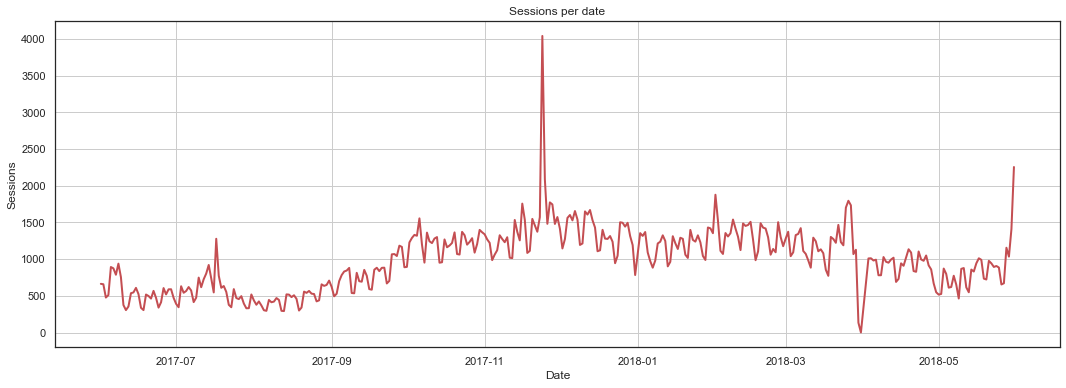

In [144]:
pd.options.mode.chained_assignment = None
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(data=sessions_per_date, x = 'date', y = 'session_cnt', color = 'r', linewidth = 2)

plt.grid(True)
plt.title('Sessions per date')
plt.xlabel('Date')
plt.ylabel('Sessions')

In [145]:
print('Среднее количество сессий в день за весь период:', int(sessions_per_date['session_cnt'].mean()))
print('Медианнае количество сессий в день за весь период:', int(sessions_per_date['session_cnt'].median()))

Среднее количество сессий в день за весь период: 987
Медианнае количество сессий в день за весь период: 1003


##### Посмтрим сколько длится одна сессия: ASL (Average Session Length).

In [146]:
visits.head(5)

,device,source id,uid,start ts,end ts,date,week,month,year,weekday,month_year,week_year
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,51,12,2017,2,2017-12,2017-51
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,8,2,2018,0,2018-02,2018-08
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,26,7,2017,5,2017-07,2017-26
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,5,2018,6,2018-05,2018-20
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,52,12,2017,2,2017-12,2017-52


In [147]:
visits['session_duration_sec'] = (visits['end ts'] - visits['start ts']).dt.seconds

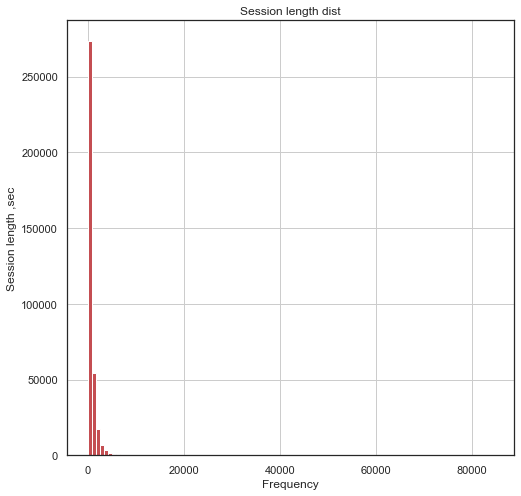

In [148]:
plt.figure(figsize=(8,8))
plt.hist(visits['session_duration_sec'], bins=100, color = 'r')
        
plt.grid(True)
plt.title('Session length dist')
plt.xlabel('Frequency')
plt.ylabel('Session length ,sec')
plt.show()

In [149]:
print('Средняя длина сессии:', int(visits['session_duration_sec'].mean()), 'сек.')
print('Медианная длина сессии:', int(visits['session_duration_sec'].median()), 'сек.')
print('Мода длины сессии (наиболее встречающаяся длина):', visits['session_duration_sec'].mode()[0], 'сек.')

Средняя длина сессии: 643 сек.
Медианная длина сессии: 300 сек.
Мода длины сессии (наиболее встречающаяся длина): 60 сек.


##### Проанализируем как часто возвращаются пользователи.

In [150]:
display(visits.head(5))

,device,source id,uid,start ts,end ts,date,week,month,year,weekday,month_year,week_year,session_duration_sec
0,touch,4,16879256277535980062,2017-12-20 17:20:00,2017-12-20 17:38:00,2017-12-20,51,12,2017,2,2017-12,2017-51,1080
1,desktop,2,104060357244891740,2018-02-19 16:53:00,2018-02-19 17:21:00,2018-02-19,8,2,2018,0,2018-02,2018-08,1680
2,touch,5,7459035603376831527,2017-07-01 01:54:00,2017-07-01 01:54:00,2017-07-01,26,7,2017,5,2017-07,2017-26,0
3,desktop,9,16174680259334210214,2018-05-20 10:59:00,2018-05-20 11:23:00,2018-05-20,20,5,2018,6,2018-05,2018-20,1440
4,desktop,3,9969694820036681168,2017-12-27 14:06:00,2017-12-27 14:06:00,2017-12-27,52,12,2017,2,2017-12,2017-52,0


###### Для начала определим когда пользватели проявили свою первую активность внашем сервисе.

In [151]:
visits['date'] = pd.to_datetime(visits['date'])

first_activity_date = visits.groupby(['uid'])['date'].min()
first_activity_date.name = 'first_activity_date'

###### Объединим получившуюся сводную таблицу с исходным датафреймом.

In [152]:
visits = visits.join(first_activity_date,on='uid') 

###### Поскольку Яндекс.Афиша - это пользвательский сервис c  мероприятиями, то мы не думаем, что пользватели ежедневно или еженедельно туда заходят. Поэтому мы сформируем когорты на месячной основе.

In [153]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['date'].astype('datetime64[M]')

In [154]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round()
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int') 

##### Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый месяц жизни.

In [155]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

##### Найдём исходное количество пользователей в когорте.

In [156]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
print(initial_users_count)

   first_activity_month    uid
0            2017-06-01  13259
12           2017-07-01  13140
23           2017-08-01  10181
33           2017-09-01  16704
42           2017-10-01  25977
50           2017-11-01  27248
57           2017-12-01  25268
63           2018-01-01  22624
68           2018-02-01  22197
72           2018-03-01  20589
75           2018-04-01  15709
77           2018-05-01  15273


##### Объединим данные по когортам с исходным количеством пользователей в когорте.

In [157]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

##### Рассчитаем Retention Rate (Коэффициент удержания).

In [158]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [159]:
cohorts.query('first_activity_month	== "2017-06-01"')

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
5,2017-06-01,5,947,13259,0.071423
6,2017-06-01,6,809,13259,0.061015
7,2017-06-01,7,766,13259,0.057772
8,2017-06-01,8,694,13259,0.052342
9,2017-06-01,9,674,13259,0.050833


##### Построим сводную таблицу и создадим отчет.

In [160]:
retention_pivot = cohorts.query('cohort_lifetime > 0').pivot_table(index='first_activity_month',
                                                                      columns='cohort_lifetime',
                                                                      values='retention',aggfunc='sum')

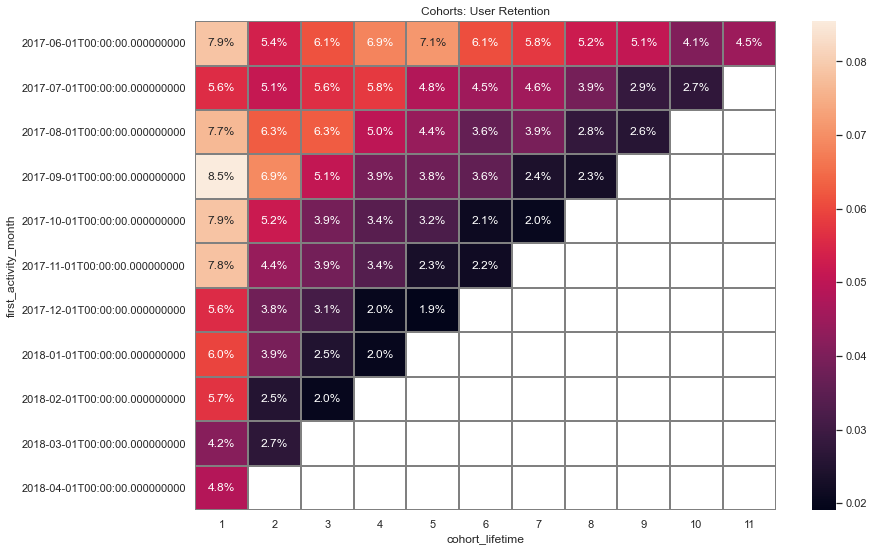

In [161]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

In [53]:
print('Средний коэффициент удержания по второму месяцу жизни всех месячных когорт: {:.1%}'
      .format(cohorts.query('cohort_lifetime == 2')['retention'].mean()))

Средний коэффициент удержания по второму месяцу жизни всех месячных когорт: 4.6%


###### Процент заядлых театралов и любителй походов в кино совсем не велик. Есть месяцы, когда ни одного пользователя когорты не было замечено. "Тепловая карта" в ее классическом виде к сожалению не получилась.

### Выводы по продуктовым метрикам: <a id="prod_conc"></a>

##### Сколько людей пользуются в день, неделю, месяц?

- В Яндекс.Афиша за период с 06-2017 по 05-2018 было ~228 тыс человек;
- Средний DAU за период 907 человек;
- Средний WAU за период 5716 человек;
- Средний MAU за период 23228 человек;

##### Сколько сессий в день?

- Среднее количество сессий в день: 987, что сопоставимо со средне-дневным числом уникальных активных пользователей. Это значит, что большинство пользователей находят что искали с первого раза и в этот же день больше не возвращаются;

##### Сколько длится одна сессия?

- Среднее время сессии составляет (ASL): 60 секунд. Мы для расчета использовали моду, так как распределение времени сессий крайне ассиметрично.

##### Как часто люди возвращаются?

- Retention Rate показываает нам, что почти по всем месячным когортам после нулевого месяца на первый возвращается не более 8,5%. По некоторым когортам есть вообще пропуски, т.е. ни одного пользователя не пришло. Вместе с тем видно, что после привлечения новых пользователей процент возвратов более-менее стабильный. Мы думаем, что это связано со спецификой. В театры и на выставки каждый день редко кто ходит.


### Метрики продаж: <a id="sales"></a>

###### Для начала сохраним еще одну копию таблицы orders . Она нам пригодится для расчета LTV.

In [54]:
orders_ltv = orders.copy()

#####  Разберемся когда люди начинают покупать.

In [55]:
display(orders.head(5))

,buy ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


##### Найдем дату первой покупки по каждому пользователю.

In [56]:
orders['date'] = orders['buy ts'].dt.date
first_order_date = orders.groupby(['uid'])['date'].min()
first_order_date.name = 'first_order_date'

##### Добавим к изначальному датафрейму с покупками столбец с первой покупкой и датой первой сессии, рассчитанную ранее.

In [57]:
orders = orders.join(first_order_date,on='uid')

In [58]:
orders = orders.join(first_activity_date,on='uid')

##### Посчитаем разницу между датой первой покупки и первой сессии

In [59]:
orders['first_order_date'] = pd.to_datetime(orders['first_order_date'])
orders['from_act_to_ord'] = pd.to_datetime(orders['first_order_date'], unit='d') - \
                            pd.to_datetime(orders['first_activity_date'], unit='d')

In [60]:
orders['from_act_to_ord'] = orders['from_act_to_ord'] / np.timedelta64(1,'D')

##### Посчитаем среднее кол-во дней от первой сессии пользователя до первой покупки.

In [61]:
orders_unique_uid = orders[['uid', 'from_act_to_ord']]
orders_unique_uid = orders_unique_uid.drop_duplicates()

In [62]:
print('Средняя количество дней от первой сессии до первой покупки:', int(orders_unique_uid['from_act_to_ord'].mean()), 'дней.')
print('Медианное количество дней от первой сессии до первой покупки:', int(orders_unique_uid['from_act_to_ord'].median()), 'дней.')
print('Мода количества дней от первой сессии до первой покупки (наиболее встречающаяся кол-во дней):',
                                      int(orders_unique_uid['from_act_to_ord'].mode()[0]), 'дней.')

Средняя количество дней от первой сессии до первой покупки: 16 дней.
Медианное количество дней от первой сессии до первой покупки: 0 дней.
Мода количества дней от первой сессии до первой покупки (наиболее встречающаяся кол-во дней): 0 дней.


##### Нулевая мода и медиана говорят о том, что многие пользватели делают покупку в первый день посещения ресурса. Проверим.

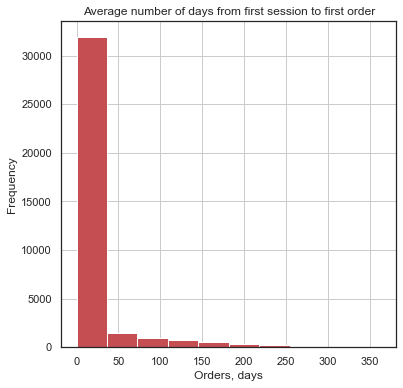

In [63]:
plt.figure(figsize=(6,6))
plt.hist(orders_unique_uid['from_act_to_ord'], bins=10, color = 'r')
        
plt.grid(True)
plt.title('Average number of days from first session to first order')
plt.xlabel('Orders, days')
plt.ylabel('Frequency')
plt.show()

##### Так и есть. В левой части графика сосредоточено большая часть всех покупок.

##### Посмотрим сколько раз пользователи сервиса покупали за период.

###### Для начала сгруппируем количество покупок по каждому юзеру.

In [64]:
order_cnt = orders.groupby(['uid'])['buy ts'].count().sort_values(ascending=False).reset_index()
order_cnt.columns = ['uid', 'cnt_ordets']

###### Посмотрим на Топ-10 самых-самых:-)

In [65]:
display(order_cnt.head(10))

,uid,cnt_ordets
0,3644482766749211722,239
1,13888745432979765063,238
2,11920452646463905188,227
3,6731421022966725351,183
4,3501596628378158474,150
5,5139615590553126732,150
6,3263486045884611639,131
7,10343016064897450067,127
8,10116135452198588850,124
9,6166747268563050393,117


######  Посчитаем среднее количество покупок.

In [66]:
print('Среднее количество покупок:', int(order_cnt['cnt_ordets'].mean()),'шт.')
print('Медианное количество покупок:', int(order_cnt['cnt_ordets'].median()),'шт.')
print('Мода количества покупок:', int(order_cnt['cnt_ordets'].mode()[0]),'шт.')

Среднее количество покупок: 1 шт.
Медианное количество покупок: 1 шт.
Мода количества покупок: 1 шт.


######  Посмотрим на распределение.

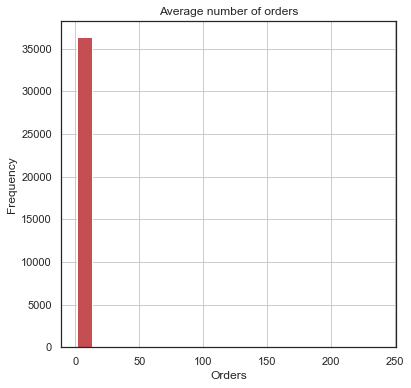

In [67]:
plt.figure(figsize=(6,6))
plt.hist(order_cnt['cnt_ordets'], bins=20, color = 'r')
        
plt.grid(True)
plt.title('Average number of orders')
plt.xlabel('Orders')
plt.ylabel('Frequency')
plt.show()

###### Такой график нам говорит лишь о том, что люди покупали в основном не более 10 раз. Посмотрим чуть ближе на тех, кто покупал больше 5 раз.

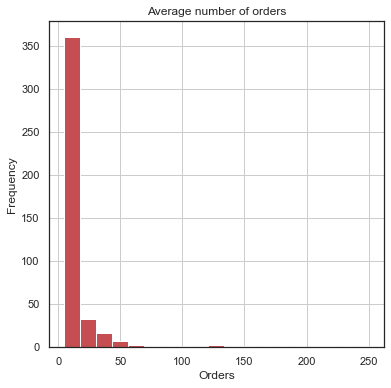

In [68]:
plt.figure(figsize=(6,6))
bins = np.linspace(5, 250, 20)  
plt.hist(order_cnt['cnt_ordets'], bins=bins, color = 'r')
      
plt.grid(True)
plt.title('Average number of orders')
plt.xlabel('Orders')
plt.ylabel('Frequency')
plt.show()

#### Все таки поход на платное мероприятия - это не за пакетом молока сходить в магазин. Такое случается В жизни наших пользователей намного реже. Заядлых любителей посещать театры, выставки и закрытые показы за деньги часто- единицы.

##### Посчитаем средний чек заказа.

In [69]:
orders.sample(5)

,buy ts,revenue,uid,date,first_order_date,first_activity_date,from_act_to_ord
19053,2017-11-24 00:36:00,0.33,520969251899509611,2017-11-24,2017-11-24,2017-11-23,1.0
43253,2018-04-06 09:53:00,5.87,9683623957060145729,2018-04-06,2018-04-06,2017-11-11,146.0
26078,2017-12-26 09:22:00,6.42,7194616172298584960,2017-12-26,2017-12-24,2017-11-24,30.0
21704,2017-12-03 18:44:00,0.73,8045011208773080359,2017-12-03,2017-12-03,2017-12-01,2.0
11123,2017-10-06 14:08:00,0.98,6623872034706041753,2017-10-06,2017-10-06,2017-10-06,0.0


##### Мы предполагаем, что выручка в столбце указана в тысячах рублей. Иначе это какой-то советский прайс.

In [70]:
print('Средний чек: {:.0f} тыс. руб.'.format(orders['revenue'].mean()))

Средний чек: 5 тыс. руб.


##### Посмотрим на минимальную и максимальную сумму заказа.

In [71]:
orders['revenue'].min()

0.0

In [72]:
orders['revenue'].max()

2633.28

##### У нас есть нулевые заказы. Скорее всего это билеты по акции. Проверим сколько таких заказов у нас было. Так как, если таких заказов много это отразится на среднем чеке.

In [73]:
orders.query('revenue == 0')['revenue'].count()

51

##### Всего 51 заказа из более чем 30 тыс заказов. Это погрешность и расчетам мешать не будет.

##### Посмотрим как средний чек менялся за весь период.

In [74]:
orders['month_year'] = pd.to_datetime(orders['buy ts']).dt.to_period('M')

In [75]:
orders_av_check = orders.groupby(['month_year'])['revenue'].mean().reset_index()
orders_av_check.columns = ['month_year', 'av_revenue']

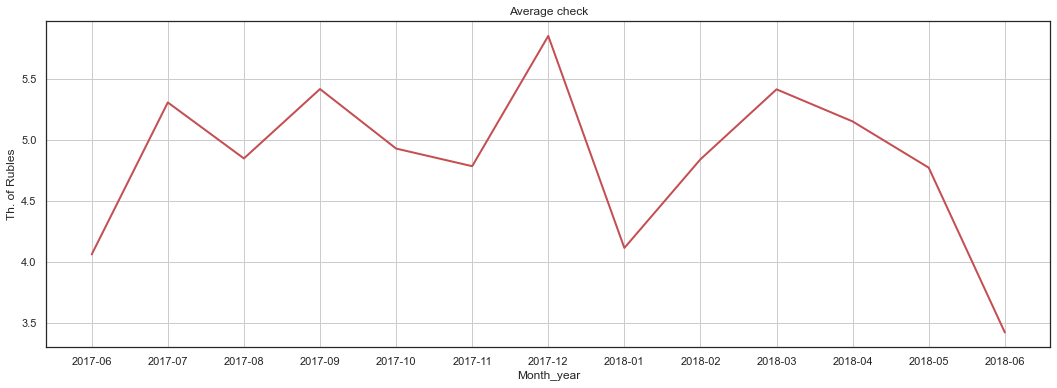

In [76]:
x = np.arange(0,len(orders_av_check),1)
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(x,orders_av_check['av_revenue'], color = 'r', linewidth = 2)
ax.set_xticks(x)
ax.set_xticklabels(orders_av_check['month_year'])

plt.grid(True)
plt.title('Average check')
plt.xlabel('Month_year')
plt.ylabel('Th. of Rubles')
plt.show()

###### Самый большой средний чек приходится на декабрь, а самый маленький на январь и июнь обоих лет. Мы можем сделать вывод, что люди охотнее тратят больше денег на походы по культурным местам перед Новым Годом, а летом предпочитают пляж и парки:-) Ну и,как правило, летом у театров каникулы.

##### Теперь посчитаем средний чек по каждой месячной когорте, чтобы взяглянуть на то как меняется поведение покупаталей с ходом времени.
   

In [77]:
orders.head()

,buy ts,revenue,uid,date,first_order_date,first_activity_date,from_act_to_ord,month_year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,0.0,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,0.0,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,0.0,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,0.0,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,0.0,2017-06


In [78]:
first_order_date_by_customers = orders.groupby('uid')['buy ts'].min()
first_order_date_by_customers.name = 'first_order_date'

orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy ts'].astype('datetime64[M]')

orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
print(orders_grouped_by_cohorts.head()) 

                               revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88


##### Найдём средний чек покупателя revenue_per_user — разделим показатель `revenue_th` на `uid`.

In [79]:
orders_grouped_by_cohorts['revenue_per_user'] = \
                    orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid'] 

###### Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени.

In [80]:
orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                      columns='order_month',
                                      values='revenue_per_user',
                                      aggfunc='mean') 

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


##### Найдём lifetime когорты. Из месяца совершения заказа `order_month` вычтем месяц когорты `first_order_month`:

In [81]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] -\
                                                orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'].head() 

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [82]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
print(orders_grouped_by_cohorts['cohort_lifetime'].head()) 

0    0.000000
1    0.985647
2    2.004148
3    3.022649
4    4.008296
Name: cohort_lifetime, dtype: float64


In [83]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].head())
print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].tail()) 

  first_order_month order_month  cohort_lifetime
0        2017-06-01  2017-06-01                0
1        2017-06-01  2017-07-01                1
2        2017-06-01  2017-08-01                2
3        2017-06-01  2017-09-01                3
4        2017-06-01  2017-10-01                4
   first_order_month order_month  cohort_lifetime
74        2018-03-01  2018-05-01                2
75        2018-04-01  2018-04-01                0
76        2018-04-01  2018-05-01                1
77        2018-05-01  2018-05-01                0
78        2018-06-01  2018-06-01                0


In [84]:
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m') 

##### Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты:

In [85]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')

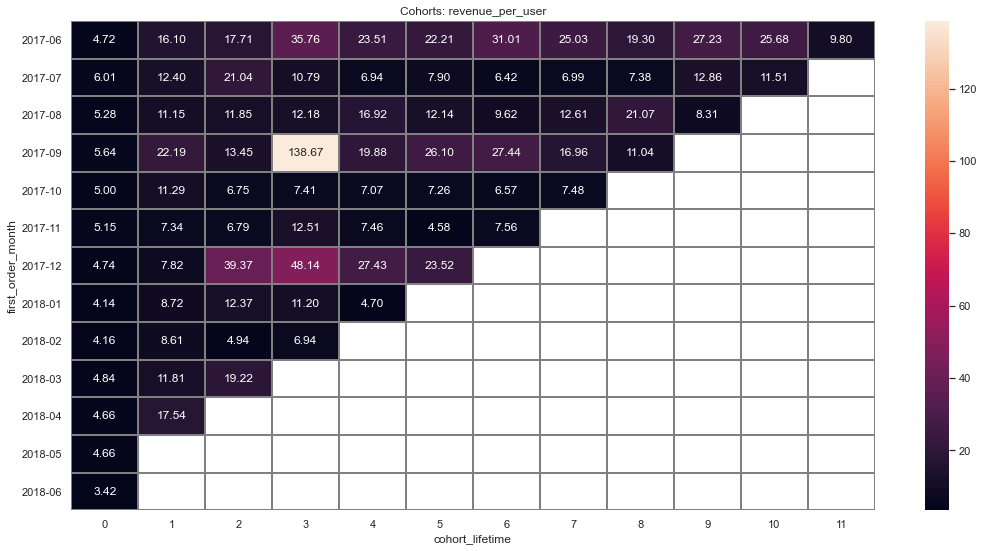

In [86]:
sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: revenue_per_user')
sns.heatmap(revenue_per_user_pivot, annot=True,fmt='.2f', linewidths=1, linecolor='gray'); 

######  В большей части месячных когорт средий чек по мере взросления растет. Это значит, что пользователи охотно покупают снова и снова на нашем ресурсе.

##### Теперь опередлим сколько денег приносит нам один пользватель за весь период.

##### Для этого посчитаем LTV ( Life Time Value). Расчет сразу произведем в разбивке по источнику привлечения клиента, так как эти данные нам понадобятся в дальнейшем исследовании.

##### Определим источник пользователя, заодно отбросим тех, кто перешел по прямой ссылке.

In [87]:
sources = visits.sort_values(by = ['uid', 'start ts']).groupby('uid').agg({'source id': 'first'})

##### Соединим первые покупки и источники.

In [88]:
payers = orders.groupby('uid').agg({'buy ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy ts': 'first_buy'})

##### Посчитаем LTV.

In [89]:
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy ts'] - ltv['first_order_date']) / np.timedelta64(1,'M')).round().astype(int)
orders_lifetime = ltv.pivot_table(index = 'source id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
buyers_lifetime = ltv.pivot_table(index = 'source id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
ltv = ltv.pivot_table(index = 'source id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

##### Добавляем размеры когорт и поделим на них, чтобы найти сколько принсосит в среднем нам один пользователь по каждому источнику привлечения.

In [90]:
cohort_sizes = payers.groupby('source id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'source id')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')

######  Построим отчет (Тепловую карту).

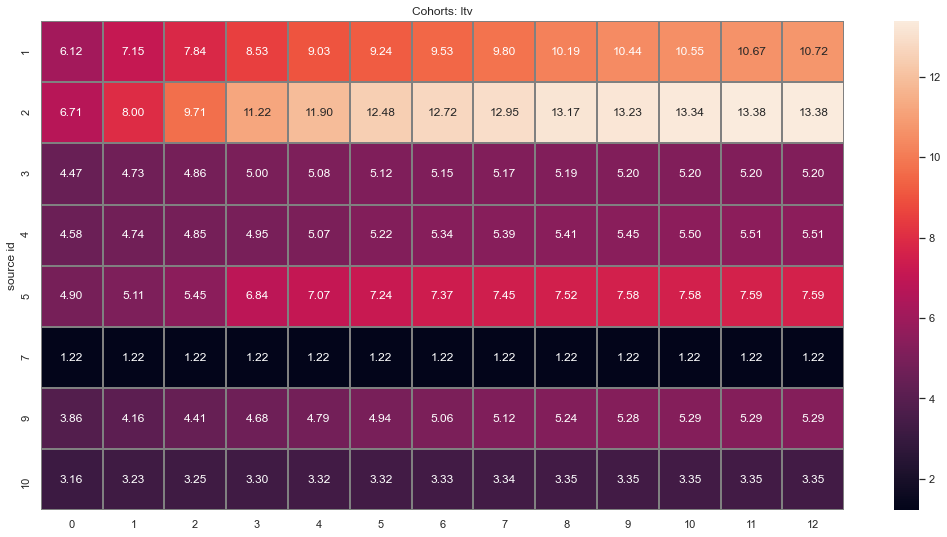

In [91]:
sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: ltv')
sns.heatmap(ltv, annot=True,fmt='.2f', linewidths=1, linecolor='gray'); 

##### Теперь посчитаем средний LTV (Life Time Value) для каждой месячной когорты, чтобы понять сколько в среднем пользователи приностя нам выручки накопительным итогом  с момента первых покупок и далее по тем покупкам лайфтайма которые они совершают.

###### Выделим месяц из даты

In [92]:
orders_ltv['order_month'] = orders_ltv['buy ts'].astype('datetime64[M]')

##### Получим месяц первой покупки для каждого клиента

In [93]:
first_orders = orders_ltv.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

##### Найдем количество новых покупателей ежемесячно

In [94]:
cohort_sizes_2 = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
first_order_month = pd.merge(orders_ltv, first_orders, on='uid')
cohorts = first_order_month.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

##### Сформируем помесячные когорты

In [95]:
report = pd.merge(cohort_sizes_2, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['uid']

###### Выведем результат

In [96]:
result = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')

result = result.cumsum(axis=1).round(2)
result

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
print('Средний LTV на одного пользователя накопительным итогом на 6-ой месяц жизни когорты: {:.2} тыс. руб.'.format(result[6].mean()))

Средний LTV на одного пользователя накопительным итогом на 6-ой месяц жизни когорты: 8.4 тыс. руб.


### Выводы по метрикам продаж: <a id="sales_conc"></a>

##### Когда люди начинают покупать?

- Средняя количество дней от первой сессии до первой покупки: 16 дней;
- Медианное количество дней от первой сессии до первой покупки: 0 дней;
- Мода количества дней от первой сессии до первой покупки (наиболее встречающаяся кол-во дней): 0 дней;
- Нулевая мода и медиана говорят о том, что много пользвателей делает покупку в первый день посещения ресурса.

##### Сколько раз покупают за период?

- Среднее количество покупок: 1 шт.
- Медианное количество покупок: 1 шт.
- Мода количества покупок: 1 шт.
- Пользователи чаще всего делали по одной покупке за весь период.

##### Какой средний чек?

- Средний чек по всем пользователям за весь период: 5 тыс рублей;
- Минимальная сумма заказа: 0 руб. Таких пользователей всего 51 из более чем ~30 тыс. Скорее всего это или ошибка выгрузки, или результат какой-то акции.
- Максимальная сумма заказа: 2,6 млн рублей. Кто-то купил место в первом ряду на Тони Робинса (шуктка) :-)
- Самый большой средний чек приходится на декабрь, а самый маленький на январь и июнь обоих лет. Мы можем сделать вывод, что люди охотнее тратят больше денег на походы по культурным местам перед Новым Годом, а летом предпочитают альтернативный досуг. Ну и, как правило, летом у театров каникулы.
- Если смотреть на средний чек в разрезе месячных когорт, то по большей части средий чек растет по мере взросления когорты. Это значит, что пользователи охотно покупают снова и снова на нашем ресурсе.


##### Сколько денег приносят? (LTV)

- Если смотреть на LTV в разрезе месячных когорт и в разбивке по рекламному источнику, то самыми привлекательными выглядят пользователи из первой и второй когорты. Они генерят больше всего выручки. Накопительным итогом за 12 месяцев "усредненный" пользователь из первой когорты сгенерил нам ~11 тыс рублей; а во второй когорте ~13 тыс рублей.
- Самый слабый показатель LTV по седьмой когорте - статичные 1.2 тыс рублей за 12 месяцев.

### Маркетинговые метрики: <a id="mark"></a>

#####  Разберемся сколько денег потратили? Всего / на каждый источник / по времени.

In [98]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [99]:
print('Всего потратили:', int(costs['costs'].sum()), 'тыс.руб.')

Всего потратили: 329131 тыс.руб.


In [100]:
print('Всего заработали:', int(orders['revenue'].sum()), 'тыс.руб.')

Всего заработали: 252057 тыс.руб.


In [101]:
costs_per_source = costs.groupby(['source_id']).agg({'costs': 'sum'}).rename(columns = {'source_id': 'costs_sum'}).reset_index()
print(costs_per_source)

   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


##### Мы видим, что некторые источники не попали в нашу группировку. Разберемся почему.

In [102]:
costs.query('source_id in [6,7,8]')

,source_id,dt,costs


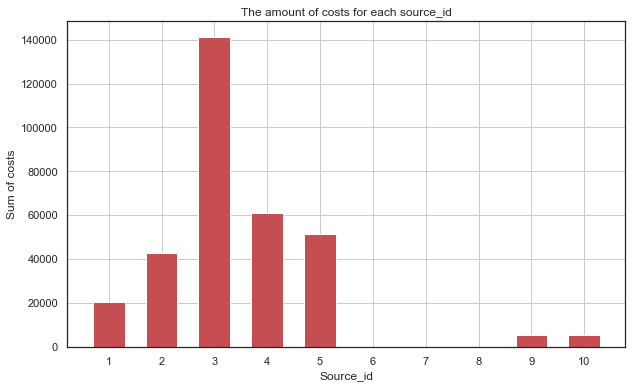

In [103]:
x = costs_per_source['source_id']
y = costs_per_source['costs']

fig, ax = plt.subplots()

ax.bar(x, y, width = 0.6, color = 'r')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

fig.set_figwidth(10)
fig.set_figheight(6)

plt.grid(True)
plt.title('The amount of costs for each source_id')
plt.xlabel('Source_id')
plt.ylabel('Sum of costs')
plt.show()

##### По ним просто не было расходов.

In [104]:
costs['month_year'] = pd.to_datetime(costs['dt']).dt.to_period('M')

In [105]:
costs_per_month = costs.groupby(['month_year']).agg({'costs': 'sum'}).rename(columns = {'month_year': 'costs_sum'}).reset_index()
print(costs_per_month)

   month_year     costs
0     2017-06  18015.00
1     2017-07  18240.59
2     2017-08  14790.54
3     2017-09  24368.91
4     2017-10  36322.88
5     2017-11  37907.88
6     2017-12  38315.35
7     2018-01  33518.52
8     2018-02  32723.03
9     2018-03  30415.27
10    2018-04  22289.38
11    2018-05  22224.27


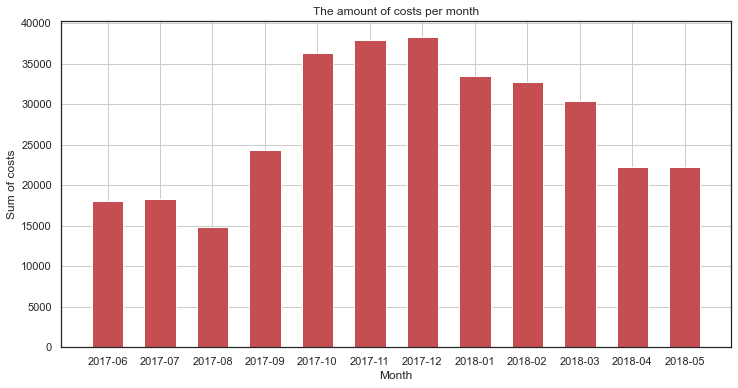

In [106]:
x = np.arange(0,len(costs_per_month),1)
y = costs_per_month['costs']

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x, y,width = 0.6, color = 'r')
ax.set_xticks(x)
ax.set_xticklabels(costs_per_month['month_year'])

plt.grid(True)
plt.title('The amount of costs per month')
plt.xlabel('Month')
plt.ylabel('Sum of costs')
plt.show()

##### Пик расходов приходится на октябрь, ноябрь и декабрь.

##### Посмотрим сколько стоило привлечение одного покупателя из каждого источника. Для этого посчитаем CAC( Customer acquisition cost).

In [107]:
cohort_sizes.reset_index()
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
cac = cac.merge(cohort_sizes, left_on = 'source_id', right_on='source id')
cac['cac'] = cac['costs'] / cac['cohort_size']
cac.rename(columns={'source_id':'source id'}, inplace=True)
cac = cac.set_index('source id')
display(cac)

,costs,cohort_size,cac
source id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10296,5.931779
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


##### Проанализируем окупаемость расходов. Посчитаем  ROMI (Return On Marketing Investment).

In [108]:
ltv.reset_index()
romi = ltv.merge(cac[['cac']], on = 'source id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')
display(romi)

,0,1,2,3,4,5,6,7,8,9,10,11,12
source id,,,,,,,,,,,,,
1,0.851823,0.994311,1.091534,1.187246,1.256402,1.286419,1.325542,1.363453,1.418138,1.453430,1.467553,1.485245,1.492351
2,0.549968,0.655629,0.794984,0.918825,0.974672,1.022032,1.041811,1.060477,1.078791,1.083886,1.092220,1.095854,1.096191
3,0.331144,0.350294,0.360459,0.370517,0.376635,0.379167,0.381402,0.383395,0.384793,0.385172,0.385559,0.385635,0.385725
4,0.771817,0.798770,0.817517,0.833841,0.854170,0.880263,0.900634,0.908672,0.912094,0.918484,0.927652,0.928106,0.928336
5,0.656549,0.684627,0.730498,0.915372,0.946874,0.969898,0.986301,0.998163,1.006381,1.014464,1.015436,1.016716,1.016750
9,0.761665,0.820953,0.869223,0.922193,0.944188,0.973254,0.997615,1.010157,1.034155,1.042150,1.043844,1.043844,1.043844
10,0.721336,0.736671,0.742894,0.753441,0.757018,0.757621,0.760704,0.762677,0.763757,0.764335,0.764335,0.764335,0.764335


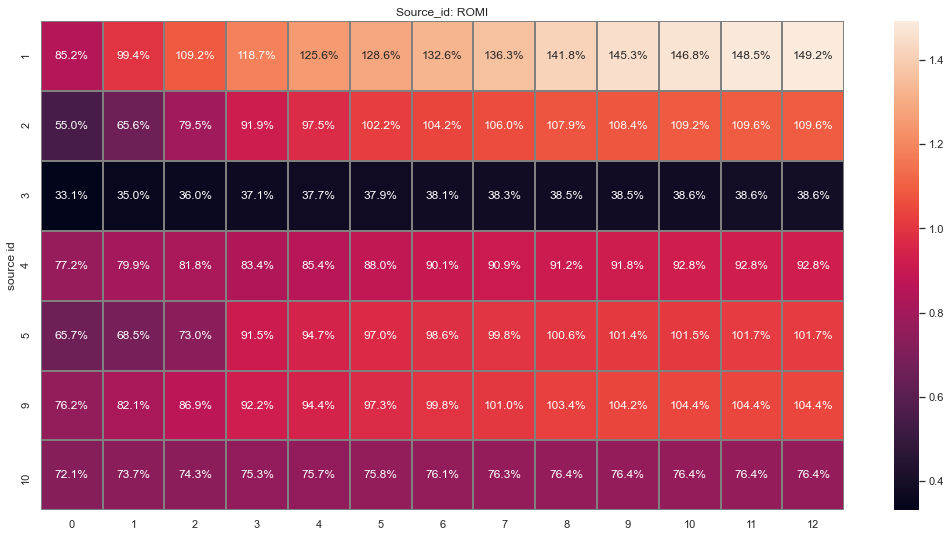

In [109]:
sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Source_id: ROMI')
sns.heatmap(romi, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

### Выводы по маркетинговым метрикам: <a id="mark_conc"></a>

##### Сколько денег потратили? Всего / на каждый источник / по времени

- Всего потратили: 329 131 тыс.руб.;
- Из 10 мы инвестировали только в 7 источников. Больше всего в источник под ID №3: 141321.63 тыс. руб.;
- Пик расходов приходится на октябрь, ноябрь и декабрь - самый сезон походов по мероприятиям.

##### Сколько стоило привлечение одного покупателя из каждого источника?

- Самым недорогим у нас получился привлеченный пользователь из источника №10: 4.38 руб.;
- Самым дорогим из №3: 13.49 руб.

##### На сколько окупились расходы? (ROI)

- По итогу 12 месяцев мы сделали вывод, что у нас окупились когорты по следующим источникам: 1,2,5 и 9;
- Аутсайдеры: 3,4 и 10.
- Лучшим каналом можно считать №1 - привлечение пользователей окупается уже на 3-ий месяц

## IV. Общий вывод : <a id="#final_conc"></a>


##### Сколько людей пользуются в день, неделю, месяц?

- В Яндекс.Афиша за период с 06-2017 по 05-2018 побывало ~228 тыс человек;
- Средний DAU за период 907 человек;
- Средний WAU за период 5716 человек;
- Средний MAU за период 23 228 человек;

##### Сколько сессий в день?

- Среднее количество сессий в день: 987, что сопоставимо со средне-дневным числом уникальных активных пользователей. Это значит, что большинство пользователей находят что искали с первого раза и в этот же день больше не возвращаются;

##### Сколько длится одна сессия?

- Среднее время сессии составляет (ASL): 60 секунд. Мы для расчета использовали моду, так как распределение времени сессий крайне ассиметрично.

##### Как часто люди возвращаются?

- Retention Rate показываает нам, что почти по всем месячным когортам после нулевого месяца на первый возвращается не более 9%. По некоторым когортам есть вообще пропуски, т.е. ни одного пользователя не пришло. Вместе с тем видно, что после привлечения новых пользователей процент возвратов более-менее стабильный. Мы думаем, что это связано со спецификой. В театры и на выстовки каждый день редко кто ходит.

##### Когда люди начинают покупать?

- Средняя количество дней от первой сессии до первой покупки: 16 дней;
- Медианное количество дней от первой сессии до первой покупки: 0 дней;
- Мода количества дней от первой сессии до первой покупки (наиболее встречающаяся кол-во дней): 0 дней;
- Нулевая мода и медиана говорят о том, что много пользвателей делает покупку в первый день посещения ресурса.

##### Сколько раз покупают за период?

- Среднее количество покупок: 1 шт.
- Медианное количество покупок: 1 шт.
- Мода количества покупок: 1 шт.
- Пользователи чаще всего делали по одной покупке за весь период.

##### Какой средний чек?

- Средний чек по всем пользователям за весь период: 5 тыс рублей;
- Минимальная сумма заказа: 0 руб. Таких пользователей всего 51 из более чем ~30 тыс. Скорее всего это или ошибка выгрузки, или результат какой-то акции.
- Максимальная сумма заказа: 2,6 млн рублей.
- Самый большой средний чек приходится на декабрь, а самый маленький на январь и июнь обоих лет. Мы можем сделать вывод, что люди охотнее тратят больше денег на походы по культурным местам перед Новым Годом, а летом предпочитают альтернативный досуг. Ну и, как правило, летом у театров каникулы.
- Если смотреть на средний чек в разрезе месячных когорт, то по большей части средий чек растет по мере взросления когорты. Это значит, что пользователи охотно покупают снова и снова на нашем ресурсе.


##### Сколько денег приносят? (LTV)

- Если смотреть на LTV в разрезе месячных когорт и в разбивке по источнику привлечения, то самыми интересными выглядят пользователи из первой и второй когорты. Они генерят больше всего выручки. Накопительным итогом за 12 месяцев "усредненный" пользователеь из первой когорты сгенерил нам ~11 тыс рублей; а во второй когорте ~13 тыс рублей.
- Самый слабый показатель LTV по седьмой когорте - статичные 1,2 тыс рублей за 12 месяцев.


##### Сколько денег потратили? Всего / на каждый источник / по времени

- Всего потратили: 329 131 тыс.руб.;
- Из 10 мы инвестировали только в 7 источников. Больше всего в источник под ID №3: 141 321.63 тыс. руб.;
- Пик расходов приходится на октябрь, ноябрь и декабрь - самый сезон походов по мероприятиям.

##### Сколько стоило привлечение одного покупателя из каждого источника?

- Самым недорогим у нас получился привлеченный пользователь из источника №10: 4.38 руб.;
- Самым дорогим из №3: 13.49 руб.

##### На сколько окупились расходы? (ROI)

- По итогу 12 месяцев мы сделали вывод, что у нас окупились когорты по следующим источникам: 1,2,5 и 9;
- Аутсайдеры: 3,4 и 10.
- Лучшим каналом можно считать №1 - привлечение пользователей окупается уже на 3-ий месяц.

### Рекомендации:
Мы рекомендуем:
- Скорректировать рекламный бюджет в сторону увеличения по источнику №1, так как CAC по ~7 рублей с окупаемостью (ROMI) на 3-ий месяц выглядят очень привлекательными по сравнению со всеми остальными;
- Отказаться от источника №3. Плата по 13 рублей за человека совсем не оправдала себя;
- Отказаться от источника №10. 4 рубля за человека это очень привлекательно, но покупки происходят в основном только в месяц привлечения, что окупает привлечение только на ~70%. В дальнейшем пользователи почти не возвращаются за повторными покупками;
- Бюджет остальных источников оставить без изменений для диверсификации. Так как со времененм поведение может меняться.